In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

In [2]:
base_dir = './input/dataset/'

# 关闭execution防止报错
tf.compat.v1.disable_eager_execution()

# 归一化处理
def process_image(image):
    return image / 255.

def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path + 'low_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = process_image(img)
            low_res_images.append(img)

    for dirname, _, filenames in os.walk(path + 'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = process_image(img)
            high_res_images.append(img)

    return np.array(low_res_images), np.array(high_res_images)

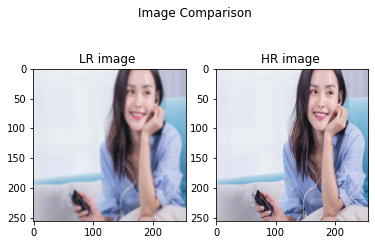

In [3]:
train_x, train_y = load_data(base_dir + 'train/')
val_x, val_y = load_data(base_dir + 'val/')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Image Comparison')
ax1.imshow(train_x[615])
ax1.title.set_text("LR image ")
ax2.imshow(train_y[615])
ax2.title.set_text("HR image ")
plt.show()

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [256,256,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()
plot_model(model, to_file ='super_res.png',show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         multiple             3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       multiple             296192      sequential_1[0][0]               
______________________

In [5]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'mean_absolute_error',
              metrics = ['acc'])

epochs=15
history=model.fit(train_x, train_y, epochs=epochs, batch_size=8, shuffle=True, 
          validation_data=(val_x, val_y))

Train on 685 samples, validate on 170 samples
Epoch 1/15
685/685 [==============================] - ETA: 0s - loss: 0.0789 - acc: 0.5682

d:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


685/685 [==============================] - 11s 16ms/sample - loss: 0.0789 - acc: 0.5682 - val_loss: 0.0479 - val_acc: 0.6218
Epoch 2/15
685/685 [==============================] - 6s 9ms/sample - loss: 0.0388 - acc: 0.7138 - val_loss: 0.0391 - val_acc: 0.8056
Epoch 3/15
685/685 [==============================] - 6s 9ms/sample - loss: 0.0331 - acc: 0.7535 - val_loss: 0.0313 - val_acc: 0.7606
Epoch 4/15
685/685 [==============================] - 6s 9ms/sample - loss: 0.0293 - acc: 0.7668 - val_loss: 0.0283 - val_acc: 0.8316
Epoch 5/15
685/685 [==============================] - 6s 9ms/sample - loss: 0.0272 - acc: 0.7736 - val_loss: 0.0281 - val_acc: 0.7974
Epoch 6/15
685/685 [==============================] - 6s 9ms/sample - loss: 0.0251 - acc: 0.7933 - val_loss: 0.0259 - val_acc: 0.7764
Epoch 7/15
685/685 [==============================] - 6s 9ms/sample - loss: 0.0239 - acc: 0.7955 - val_loss: 0.0245 - val_acc: 0.8185
Epoch 8/15
685/685 [==============================] - 6s 9ms/sample - l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


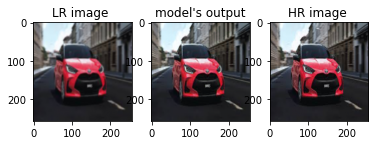

In [6]:
predict_y = model.predict(val_x)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(val_x[3])
ax1.title.set_text("LR image ")

ax2.imshow(predict_y[3])
ax2.title.set_text("model's output")

ax3.imshow(val_y[3])
ax3.title.set_text("HR image ")
plt.show()

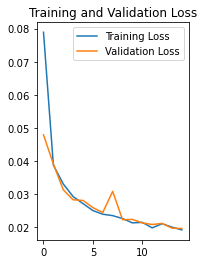

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


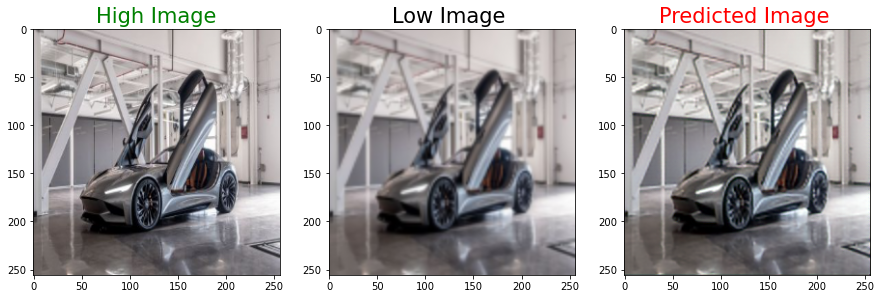

C:\Users\lenovo\AppData\Local\Temp/ipykernel_13716/2757235926.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr = compare_psnr(hr, pre)
d:\python\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.642351297727775，SSIM：0.952094347059219


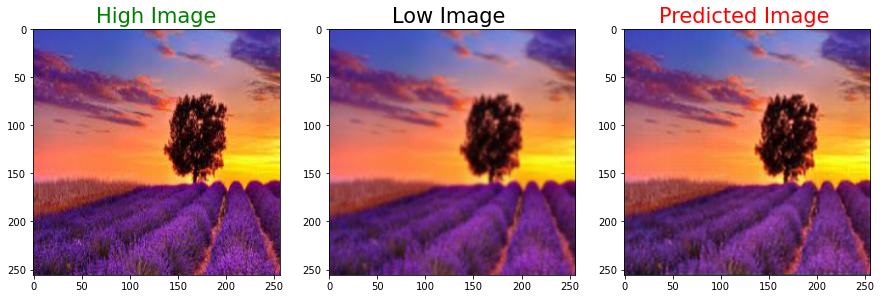

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.94298224829987，SSIM：0.929170622174444


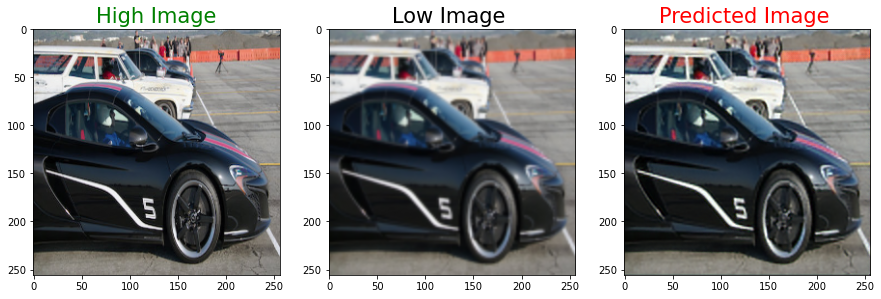

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：28.151334835586713，SSIM：0.9382178959082538


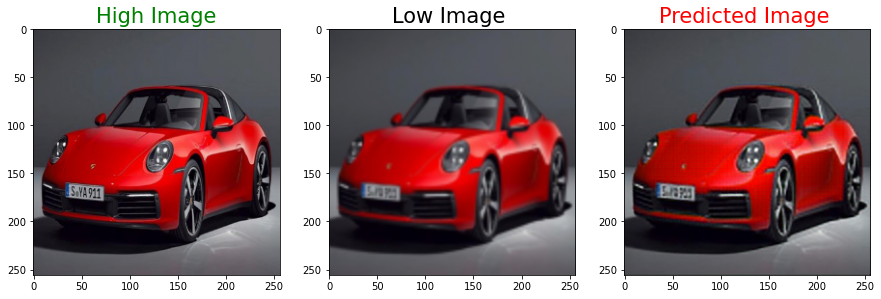

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.45766403978622，SSIM：0.9263537155052021


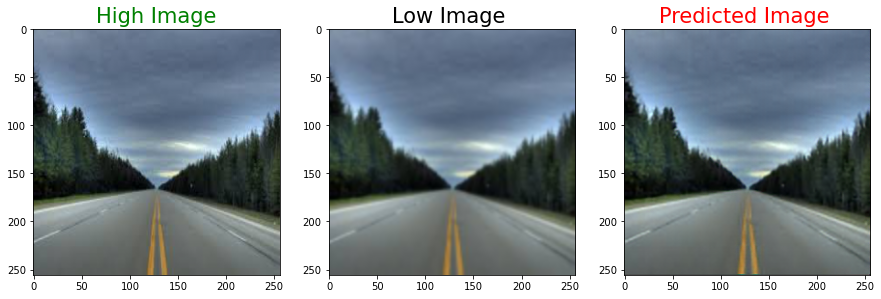

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：36.957592992703006，SSIM：0.9865517169580803


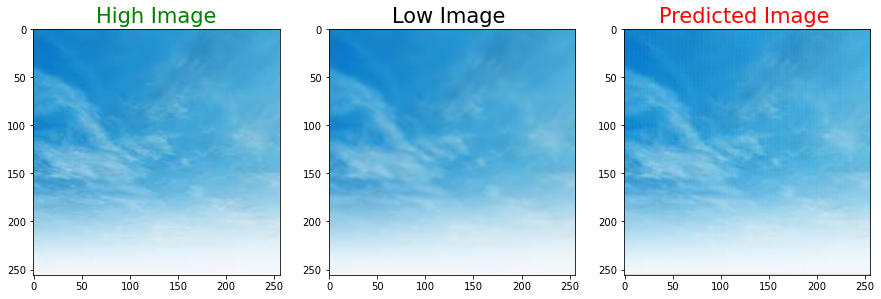

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：35.26976807506672，SSIM：0.9839872901259249


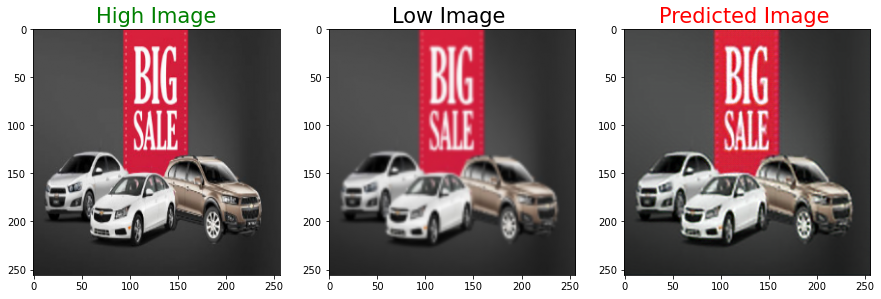

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：28.6506053408287，SSIM：0.9638944075666372


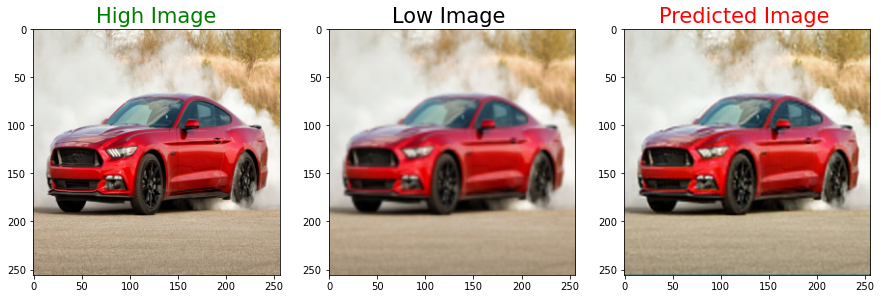

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.326663326985376，SSIM：0.9314707706062958


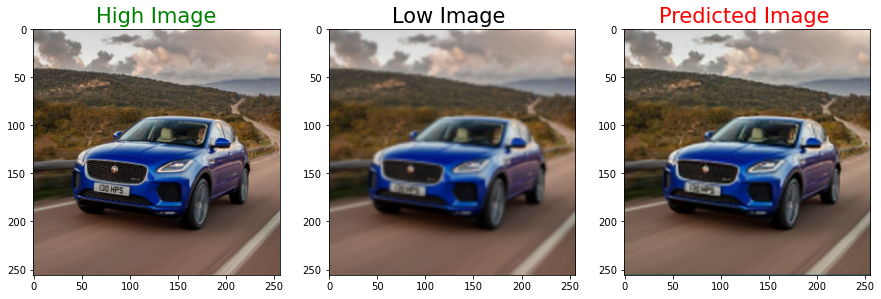

原图和输出图像比较后，PSNR：30.570005233760092，SSIM：0.956316087297906


In [8]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High Image', color='green', fontsize=21)
    plt.imshow(high)
    plt.subplot(1, 3, 2)
    plt.title('Low Image ', color='black', fontsize=21)
    plt.imshow(low)
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image ', color='red', fontsize=21)
    plt.imshow(predicted)

    plt.show()
   
def PSNR_SSIM(hr, pre):
    psnr = compare_psnr(hr, pre)
    ssim = compare_ssim(hr, pre, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print('原图和输出图像比较后，PSNR：{}，SSIM：{}'.format(psnr, ssim))


for i in range(16, 25):
    #predict_y = np.clip(model.predict(val_x[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    plot_images(val_y[i], val_x[i], predict_y[i])
    #print('PSNR', PSNR(val_y[i], predict_y[i]), 'dB')
    PSNR_SSIM(val_y[i],predict_y[i])

In [9]:
model.save('super_res.h5')